### 載入所需的Libraries

In [81]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [108]:
sms_data = pd.read_csv("data/Day17_spam.csv", encoding='latin', usecols = ['v1','v2'])
sms_data.columns = ["label", "content"]
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [109]:
# check how many spams and hams
sms_data.groupby("label").count()

,content
label,
ham,4825
spam,747


In [110]:
# change label from string to number
# "ham" --> 0, "spam" --> 1

sms_data["label"] = sms_data["label"].replace("ham", 0)
sms_data["label"] = sms_data["label"].replace("spam", 1)

sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [111]:
sms_train, sms_test = train_test_split(sms_data, test_size=0.2, stratify=sms_data.label)
sms_train = sms_train.reset_index(drop=True)
sms_test = sms_test.reset_index(drop=True)

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [112]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # make all content to lowercase and remove all punctuations
    for i in range(len(df)):
        df.loc[i, "content"] = re.sub(r"[\W\d]+", " ", df.loc[i, "content"].lower())
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
   label                                            content
0      0                       sir waiting for your letter 
1      0  nothing but we jus tot u would ask cos u ba gu...
2      0  got it it looks scrumptious daddy wants to eat...
3      0  nice talking to you please dont forget my pix ...
4      0                 prepare to be pounded every night 
Test:
   label                                            content
0      0  okay lor wah like that def they wont let us go...
1      0  you do your studies alone without anyones help...
2      0  he telling not to tell any one if so treat for...
3      0  nope wif my sis lor aft bathing my dog then i ...
4      0                                are you in the pub 


In [116]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7765

### TF-IDF
可以發現總共有7765個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [117]:
vectorizer = TfidfVectorizer(max_features=2000)

tf_idf_train = vectorizer.fit_transform(x_train)
tf_idf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(array([[3306, 5343, 6500, ..., 6138, 6137, 6135],
        [3094, 6851, 6607, ..., 6142, 6141, 6140],
        [5121, 3414, 1374, ..., 6139, 6138, 6137],
        ...,
        [5616, 1233, 2536, ..., 6145, 6144, 6143],
        [4407, 1195, 3278, ..., 6140, 6139, 6138],
        [4293, 5746, 3835, ..., 6138, 6136, 6161]]),
 array([[6004, 1442, 6492, ..., 6142, 6141, 6140],
        [5703,  179, 6700, ..., 6140, 6139, 6138],
        [2640, 5918, 6198, ..., 6141, 6140, 6139],
        ...,
        [1580, 5721, 2421, ..., 6142, 6141, 6140],
        [ 883, 2738, 1162, ..., 6145, 6144, 6143],
        [5151, 3052, 3328, ..., 6136, 6161, 6109]]))

### 建立共現矩陣

In [118]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    # initialize co-occurrence matrix
    co_matrix = np.zeros((len(vocab_list), len(vocab_list)))
    
    for idx, sms in enumerate(corpus):
        sms_ids = [word2idx[word] for word in sms.split() if word in word2idx]
        for center_idx, center_word_id in enumerate(sms_ids):
            left_idx = center_idx - window_size if center_idx - window_size >= 0 else 0
            right_idx = center_idx + window_size if center_idx + window_size < len(sms_ids) \
                else len(sms_ids)-1
            
            for neighbor_idx in range(left_idx, right_idx):
                if neighbor_idx == center_idx:
                    continue
                else:
                    if use_weighting:
                        distance = abs(center_idx - neighbor_idx)
                        co_matrix[center_word_id, sms_ids[neighbor_idx]] += 1./distance
                    else:
                        co_matrix[center_word_id, sms_ids[neighbor_idx]] += 1.
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1.0)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### 建立PPMI矩陣
$$
\begin{aligned}
&PMI(x,y) = log_2\frac{P(x,y)}{P(x)P(y)} = log_2\frac{C(x,y)N}{C(x)C(y)} \\
&PPMI(x,y) = max(0,PMI(x,y))
\end{aligned}
$$

In [119]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros((co_matrix.shape[0], co_matrix.shape[1]))
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    
    cnt = 0
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2((co_matrix[i, j] * N) / (S[i]*S[j] + eps) )
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10000000 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

<ipython-input-119-63ad7866f387>:13: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2((co_matrix[i, j] * N) / (S[i]*S[j] + eps) )


array([[ 9.37117564,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 11.40236935,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 17.27956825, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.83736989,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         8.47212389,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  9.73438926]])

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.78353829428598
Number of components = 20 and explained variance = 0.8449747094315281
Number of components = 30 and explained variance = 0.8754270927508175
Number of components = 40 and explained variance = 0.8953889574015261
Number of components = 50 and explained variance = 0.9102161045663425
Number of components = 60 and explained variance = 0.9216775084826673
Number of components = 70 and explained variance = 0.9308289912684313
Number of components = 80 and explained variance = 0.9383786347290012
Number of components = 90 and explained variance = 0.9446373478795685
Number of components = 100 and explained variance = 0.9497704867400043
Number of components = 110 and explained variance = 0.9541247775689832
Number of components = 120 and explained variance = 0.9578767641758137
Number of components = 130 and explained variance = 0.9611624556939208
Number of components = 140 and explained variance = 0.963955295581456
Number of componen

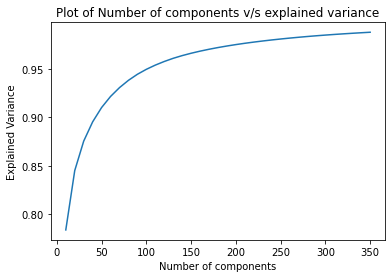

In [122]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,360,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
    svd.fit(co_matrix)
    var_sum = svd.explained_variance_ratio_.sum()
    variance_sum.append(var_sum)
    print(f"Number of components = {dim} and explained variance = {var_sum}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

Number of components = 10 and explained variance = 0.05603794140449632
Number of components = 20 and explained variance = 0.08828288887294143
Number of components = 30 and explained variance = 0.11647694404650238
Number of components = 40 and explained variance = 0.1427813739348782
Number of components = 50 and explained variance = 0.16735388947591703
Number of components = 60 and explained variance = 0.1907532262710286
Number of components = 70 and explained variance = 0.21278149063719046
Number of components = 80 and explained variance = 0.23381389235123898
Number of components = 90 and explained variance = 0.2541030385556891
Number of components = 100 and explained variance = 0.2734014050796899
Number of components = 110 and explained variance = 0.291803535961016
Number of components = 120 and explained variance = 0.3096531279318038
Number of components = 130 and explained variance = 0.3267804848637397
Number of components = 140 and explained variance = 0.34318028266921363


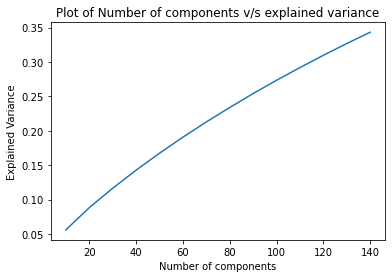

In [123]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
    svd.fit(ppmi_matrix)
    var_sum = svd.explained_variance_ratio_.sum()
    variance_sum.append(var_sum)
    print(f"Number of components = {dim} and explained variance = {var_sum}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [127]:
# choose 350 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
svd = TruncatedSVD(n_components=350)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)
re_co_matrix

array([[ 1.97018492, -1.12473163, -0.14851761, ...,  0.18122662,
        -0.11810849, -0.11992233],
       [ 1.54963048, -0.33014941, -0.80696007, ..., -0.02232469,
        -0.025253  ,  0.05717796],
       [ 1.03211177, -0.16768466,  0.12500815, ...,  0.0223668 ,
         0.06108508, -0.00991561],
       ...,
       [ 4.0198057 ,  0.80032363, -0.03128045, ...,  0.48237288,
         0.21797823, -0.19636752],
       [ 1.25873446, -0.69893939,  0.01261673, ..., -0.01036661,
         0.08947656,  0.05213968],
       [ 1.20301918,  0.2262232 , -0.92665543, ...,  0.09865896,
         0.07946129, -0.07534688]])

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [125]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vector
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 365 doesn't contain word in vocab_list
audrie lousy autocorrect


document 1010 doesn't contain word in vocab_list
 


document 1182 doesn't contain word in vocab_list
erutupalam thandiyachu


document 3181 doesn't contain word in vocab_list
hanks lotsly 


document 3610 doesn't contain word in vocab_list
u 


document 3715 doesn't contain word in vocab_list
 


document 3965 doesn't contain word in vocab_list
g w r


document 3995 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 4012 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli 


document 4197 doesn't contain word in vocab_list
k k congratulation 


document 4214 doesn't contain word in vocab_list
 tf p


document 70 doesn't contain word in vocab_list
 


document 303 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 332 doesn't contain word in vocab_list
east coast


document 793 doesn't contain word in vocab_list
ring

In [128]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(doc_vec_train, y_train_filter)
train_pred = neigh.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = neigh.predict(doc_vec_test)

In [129]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.975033738191633
train acc: 0.9657657657657658
